# 数据预处理
- 异常值检测
- 数据归一化处理
- 除去相关度低的attribute
- 除去方差小的属性
- （最后手段）利用主成分分析进行数据降维

# 随机森林实现

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import ensemble # ensemble learning: 集成学习
from sklearn import preprocessing
import sklearn.tree as tree
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import shap

In [2]:
df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv') 
df = df.sort_values(by=' timedelta',ascending=False)  #发布时间从早到晚
# df.head()
# print('shares: ', Counter(df[' shares']>1400))   # True 19562; False 20082
# print(df[' shares'])
y = (df[' shares']>1400)*1
X = df.iloc[:, 2:-1]
# X = preprocessing.scale(df.iloc[:, 2:-1])   # 数据归一化,应放在划分训练集之后

# # PCA降维，不如不降（
# pca = PCA(n_components=36)  
# X_new = pca.fit_transform(X)
# print(pca.explained_variance_ratio_.sum()) #降维后信息保留量应大于95%

# X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
#                                     test_size=0.3, random_state=12345)
# 保证训练集时间早于测试集
train_size = int(0.7*df.shape[0])
X_train = X.iloc[0:train_size,:]
X_test = X.iloc[train_size:df.shape[0]+1,:]
y_train = y.iloc[0:train_size]
y_test = y.iloc[train_size:df.shape[0]+1]
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

## 普通决策树

In [49]:
# 直接使用交叉网格搜索来优化决策树模型，边训练边优化
# 网格搜索的参数：正常决策树建模中的参数 - 评估指标，树的深度，
 ## 最小拆分的叶子样本数与树的深度
param_grid = {'criterion': ['entropy', 'gini'],
             'max_depth': [2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [4, 8, 12, 16, 20, 24, 28]} 
                # 通常来说，十几层的树已经是比较深了

clf = tree.DecisionTreeClassifier()  # 定义一棵树
clfcv = GridSearchCV(estimator=clf, param_grid=param_grid, 
                            scoring='roc_auc', cv=4) 
        # 传入模型，网格搜索的参数，评估指标，cv交叉验证的次数

clfcv.fit(X=X_train, y=y_train)  # 训练
# 使用模型来对测试集进行预测
test_est = clfcv.predict(X_test)


In [50]:
# 模型评估
print("决策树准确度:")
# print(metrics.classification_report(y_test,test_est))  # 列出各项指标
# print("决策树 AUC:")
# fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, test_est)
# print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))
print('accuracy     '+str(accuracy_score(y_test,test_est)))
print('precision    '+str(precision_score(y_test,test_est)))
print('recall       '+str(recall_score(y_test,test_est)))
print('f1_score     '+str(f1_score(y_test,test_est)))
print('AUC          '+str(roc_auc_score(y_test,test_est)))

决策树准确度:
accuracy     0.6359508996132504
precision    0.6001099102399707
recall       0.6040936750875899
f1_score     0.6020952030876677
AUC          0.6333712078111416


## 随机森林

In [51]:
# 使用随机森林对测试集进行预测
param_grid = {
    # 'criterion':['entropy','gini'],
    'max_depth':[5, 6, 7, 8],    # 深度：这里是森林中每棵决策树的深度
    'n_estimators':[10, 20, 50, 100, 200, 400],  # 决策树个数-随机森林特有参数
    # 'max_features':[0.3,0.4,0.5],
    #  # 每棵决策树使用的变量占比-随机森林特有参数（结合原理）
    'min_samples_split':[4,8,12,16]  # 叶子的最小拆分样本量
}

rfc = ensemble.RandomForestClassifier()
rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid,
                      scoring='roc_auc', cv=4)
rfc_cv.fit(X_train, y_train)
test_est = rfc_cv.predict(X_test)

In [52]:
print('随机森林精确度:')
print(metrics.classification_report(y_test, test_est))
print('随机森林 AUC:')
fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, test_est)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))
print('accuracy     '+str(accuracy_score(y_test,test_est)))
print('precision    '+str(precision_score(y_test,test_est)))
print('recall       '+str(recall_score(y_test,test_est)))
print('f1_score     '+str(f1_score(y_test,test_est)))
print('AUC          '+str(roc_auc_score(y_test,test_est)))

随机森林精确度:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      6471
           1       0.64      0.63      0.64      5423

    accuracy                           0.67     11894
   macro avg       0.67      0.67      0.67     11894
weighted avg       0.67      0.67      0.67     11894

随机森林 AUC:
AUC = 0.6659
accuracy     0.6686564654447621
precision    0.637120651369356
recall       0.6348884381338742
f1_score     0.6360025861272743
AUC          0.665922043205401


# xgboost实现

In [3]:
# 训练模型
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=160, objective='binary:logistic')
# model = xgb.XGBClassifier(num_class=2, max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='multi:softmax')
model.fit(X_train, y_train)

# 对测试集进行预测
ans = model.predict(X_test)

In [68]:
print('xgboost精确度:')
print(metrics.classification_report(y_test,ans))
print('accuracy     '+str(accuracy_score(y_test,ans)))
print('precision    '+str(precision_score(y_test,ans)))
print('recall       '+str(recall_score(y_test,ans)))
print('f1_score     '+str(f1_score(y_test,ans)))
print('AUC          '+str(roc_auc_score(y_test,ans)))
print('xgboost AUC:')
fpr_test, tpr_test, th_test = metrics.roc_curve(y_test,ans)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

xgboost精确度:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      2235
           1       0.63      0.54      0.58      1730

    accuracy                           0.66      3965
   macro avg       0.65      0.65      0.65      3965
weighted avg       0.66      0.66      0.66      3965

accuracy     0.6597730138713745
precision    0.6275954454119224
recall       0.5416184971098266
f1_score     0.5814458578963699
AUC          0.6464244610828774
xgboost AUC:
AUC = 0.6464


## 可解释性

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


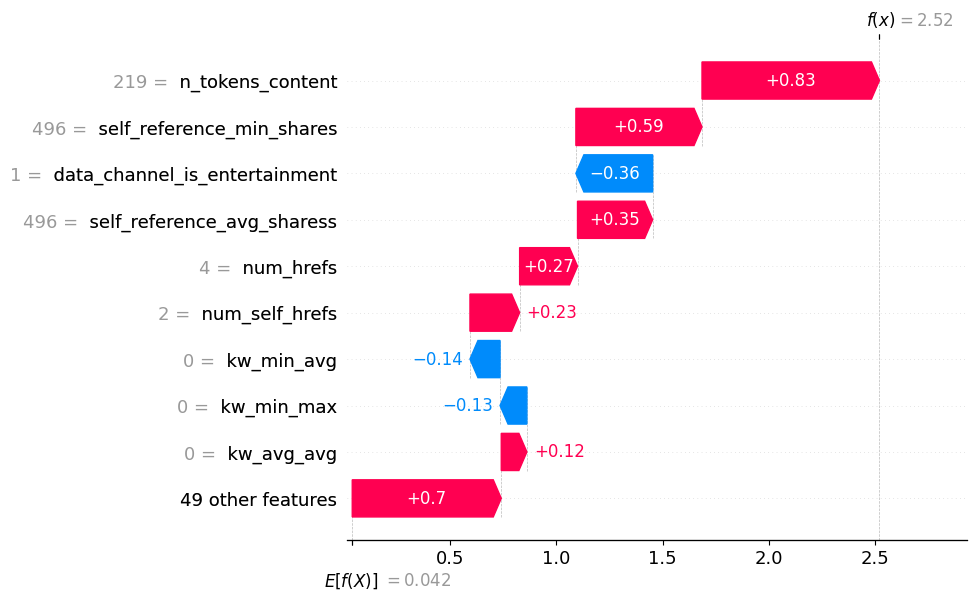

In [4]:
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(X)
# waterfall图描述特征对第0个样本的正/负增益
shap.plots.waterfall(shap_values[0])
# force plot图

In [5]:
# force plot,visualize all the training set predictions
shap.plots.force(shap_values[0:100])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


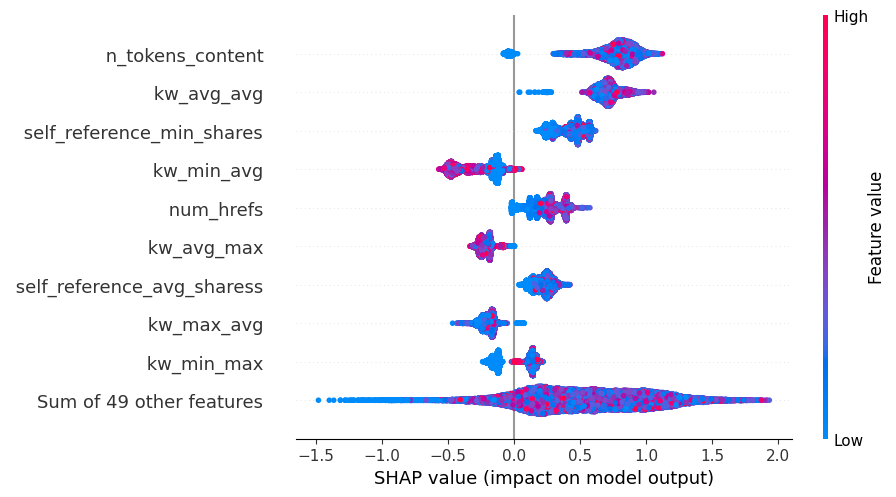

In [6]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)